## Importing libraries

In [32]:
import pandas as pd
import numpy as np

import time
from tqdm import tqdm_notebook

In [10]:
import gcsfs

In [11]:
import glob

In [12]:
import pyarrow

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [8]:
import seaborn as sns

Spark libraries

In [1]:
import pyspark

In [15]:
from pyspark.sql.functions import when, col
import pyspark.sql.types as pst
import pyspark.sql.functions as psf

Dask libraries

In [6]:
from dask.distributed import Client, progress, LocalCluster
import dask

In [7]:
import dask.dataframe as dd

## Preparing dataset

### Converting data to hourly information for each neighborhood

In [2]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [16]:
pyspark.__version__

'2.4.4'

In [ ]:
gcsfs.GCSFileSystem(project='project-name')

First try with one month - January 2018

In [20]:
%time data_2018_01_par = spark.read.parquet('gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018/yellow_tripdata_2018-01.parquet/')

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.74 s


In [21]:
data_2018_01_par

DataFrame[Unnamed: 0: bigint, VendorID: bigint, tpep_pickup_datetime: timestamp, tpep_dropoff_datetime: timestamp, passenger_count: bigint, trip_distance: double, RatecodeID: bigint, store_and_fwd_flag: bigint, PULocationID: bigint, DOLocationID: bigint, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, index: bigint]

In [22]:
def show(df, n=5):
    return df.limit(n).toPandas()

Selecting only the columns I will use later - Time, Location and Fare

In [164]:
fare_df = data_2018_01_par.select(
            psf.to_timestamp(data_2018_01_par['tpep_pickup_datetime'], 'yyyy-MM-dd HH:mm:ss').alias('dt'),
            data_2018_01_par.PULocationID,
            data_2018_01_par.fare_amount)

In [165]:
show(fare_df)

,dt,PULocationID,fare_amount
0,2018-01-03 17:43:56,211,10.5
1,2018-01-03 17:59:09,186,5.5
2,2018-01-03 17:14:59,229,36.0
3,2018-01-03 17:18:01,142,8.0
4,2018-01-03 17:31:10,239,12.0


### Hourly demand

To calculate pick-up demand I am grouping everything by date and hour and pivoting the table to have separate information for each location. This way I calculate the count of taxi pick-up at each location at each our of the year.

In [166]:
%time demand_neigh = (fare_df.groupBy(psf.date_format('dt', 'yyyy-MM-dd HH').alias('ds')).pivot('PULocationID').count().orderBy('ds').toPandas())

CPU times: user 68 ms, sys: 8 ms, total: 76 ms
Wall time: 1min 20s


In [48]:
demand_neigh['ds'] = pd.to_datetime(demand_neigh['ds'])
demand_neigh.set_index('ds', inplace=True)

Save data for January 2018

In [170]:
demand_neigh.to_parquet('gs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_2018-01a.parquet')

Preparing helper function to do the same for every month in 2018

In [71]:
def conv_to_parq(i):
    df = spark.read.parquet(f'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018/yellow_tripdata_2018-{i}.parquet/')
    
    # selecting proper columns
    df = df.select(
            psf.to_timestamp(df['tpep_pickup_datetime'], 'yyyy-MM-dd HH:mm:ss').alias('dt'),
            df.PULocationID,
            df.fare_amount)
    
    # hourly and by location data grouping
    demand_df = (df.groupBy(psf.date_format('dt', 'yyyy-MM-dd HH').alias('ds')).pivot('PULocationID').count().orderBy('ds').toPandas())
    
    # saving to parquet file
    demand_df.to_parquet(f'gs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_2018-{i}.parquet', engine = 'pyarrow')

Iterating through each month

In [62]:
months = ['02', '03','04', '05', '06', '07', '08', '09', '10', '11', '12']
gs_path = 'gs://nyc-taxi-data-2018-2019'
full_2018 = [gs_path + f'/nyc_neighborhoods/yellow_neigh_demand_2018-{i}.parquet' for i in months]

In [ ]:
y = []
for x in tqdm_notebook(months):
    conv_to_parq(x)

In [75]:
demand_df.head()

,ds,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
0,2008-12-31 05,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,NaN,None,None,None
1,2008-12-31 07,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,NaN,None,None,None
2,2008-12-31 09,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,2.0,None,None,None
3,2008-12-31 11,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,NaN,None,None,None
4,2008-12-31 17,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,NaN,None,None,None


### Hourly average fare

To have information about fare in each neighborhood I am grouping everything hourly and calculating the mean value for each neighborhood.

In [164]:
fare_df = data_2018_01_par.select(
            psf.to_timestamp(data_2018_01_par['tpep_pickup_datetime'], 'yyyy-MM-dd HH:mm:ss').alias('dt'),
            data_2018_01_par.PULocationID,
            data_2018_01_par.fare_amount)

In [173]:
%time fare_neigh = (fare_df.groupBy(psf.date_format('dt', 'yyyy-MM-dd HH').alias('ds')).pivot('PULocationID').mean('fare_amount').orderBy('ds').toPandas())

CPU times: user 72 ms, sys: 16 ms, total: 88 ms
Wall time: 1min 30s


In [82]:
fare_neigh['ds'] = pd.to_datetime(fare_neigh['ds'])
fare_neigh.set_index('ds', inplace=True)

Save data for January 2018

In [174]:
%time fare_neigh.to_parquet('gs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_2018-01.parquet')

CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 507 ms


Preparing helper function to do the same for every month in 2018

In [103]:
def conv_to_parq_fare(i):
    df = spark.read.parquet(f'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018/yellow_tripdata_2018-{i}.parquet/')
    
    # selecting proper columns
    df = df.select(
            psf.to_timestamp(df['tpep_pickup_datetime'], 'yyyy-MM-dd HH:mm:ss').alias('dt'),
            df.PULocationID,
            df.fare_amount)
    
    # hourly and by location data grouping and averaging
    fare_neigh = (df.groupBy(psf.date_format('dt', 'yyyy-MM-dd HH').alias('ds')).pivot('PULocationID').mean('fare_amount').orderBy('ds').toPandas())
    
    # saving to parquet file
    fare_neigh.to_parquet(f'gs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_2018-{i}.parquet', engine = 'pyarrow')

Iterating through each month

In [104]:
for x in tqdm_notebook(months):
    conv_to_parq_fare(x)

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


### Hourly average trip distance

To have information about trip distance in each neighborhood I am grouping everything hourly and calculating the mean value for each neighborhood.

In [105]:
trip_df = data_2018_01_par.select(
            psf.to_timestamp(data_2018_01_par['tpep_pickup_datetime'], 'yyyy-MM-dd HH:mm:ss').alias('dt'),
            data_2018_01_par.PULocationID,
            data_2018_01_par.trip_distance)

In [106]:
show(trip_df)

,dt,PULocationID,trip_distance
0,2018-01-03 17:43:56,211,2.10
1,2018-01-03 17:59:09,186,0.60
2,2018-01-03 17:14:59,229,8.00
3,2018-01-03 17:18:01,142,1.62
4,2018-01-03 17:31:10,239,2.01


In [177]:
%time trip_neigh = (trip_df.groupBy(psf.date_format('dt', 'yyyy-MM-dd HH').alias('ds')).pivot('PULocationID').mean('trip_distance').orderBy('ds').toPandas())

CPU times: user 84 ms, sys: 4 ms, total: 88 ms
Wall time: 1min 19s


In [216]:
trip_neigh[(trip_neigh.ds > '2018-01')]

,ds,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
29,2018-01-01 00,NaN,NaN,6.2,2.652874,NaN,NaN,2.970488,NaN,NaN,...,3.702500,1.170000,NaN,NaN,3.175000,4.034545,2.361492,2.453485,2.433731,0.345000
30,2018-01-01 01,NaN,NaN,6.9,3.013571,NaN,NaN,3.177400,NaN,0.8,...,3.663288,3.708333,NaN,NaN,3.579474,4.146000,2.769487,2.529883,2.735600,0.425455
31,2018-01-01 02,NaN,NaN,NaN,3.018954,0.0,NaN,2.709398,NaN,NaN,...,3.200421,7.220000,NaN,NaN,3.658864,5.358519,2.782340,2.428959,2.709448,2.988500
32,2018-01-01 03,0.01,NaN,NaN,3.301881,NaN,NaN,2.734860,NaN,NaN,...,3.177800,9.480000,8.47,NaN,1.702333,4.015556,2.829434,2.456787,2.873709,1.160400
33,2018-01-01 04,0.00,NaN,NaN,3.257273,NaN,NaN,3.900377,NaN,NaN,...,2.627679,NaN,NaN,1.205,3.268780,5.260556,4.097083,2.741822,3.102968,4.867391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,2018-02-01 21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
790,2018-02-01 23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
791,2018-07-27 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
792,2018-07-27 03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
trip_neigh['ds'] = pd.to_datetime(trip_neigh['ds'])
trip_neigh.set_index('ds', inplace=True)

Saving data for January 2018

In [178]:
trip_neigh.to_parquet(f'gs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_2018-01.parquet', engine = 'pyarrow')

Preparing helper function to do the same for every month in 2018

In [126]:
def conv_to_parq_trip(i):
    df = spark.read.parquet(f'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018/yellow_tripdata_2018-{i}.parquet/')
    df = df.select(
            psf.to_timestamp(df['tpep_pickup_datetime'], 'yyyy-MM-dd HH:mm:ss').alias('dt'),
            df.PULocationID,
            df.trip_distance)
    trip_neigh = (df.groupBy(psf.date_format('dt', 'yyyy-MM-dd HH').alias('ds')).pivot('PULocationID').mean('trip_distance').orderBy('ds').toPandas())
    trip_neigh.to_parquet(f'gs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_2018-{i}.parquet', engine = 'pyarrow')

Iterating through each month

In [127]:
for x in tqdm_notebook(months):
    conv_to_parq_trip(x)

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


### Hourly tips for the drivers

To get about tips for the drivers in each neighborhood I am grouping everything hourly and calculating the mean value for each neighborhood.

In [128]:
tips_df = data_2018_01_par.select(
            psf.to_timestamp(data_2018_01_par['tpep_pickup_datetime'], 'yyyy-MM-dd HH:mm:ss').alias('dt'),
            data_2018_01_par.PULocationID,
            data_2018_01_par.tip_amount,
            data_2018_01_par.total_amount)

In [133]:
tips_df = tips_df.select('*', (tips_df.tip_amount / tips_df.total_amount).alias('tip_ratio'))

In [217]:
show(tips_df, n=10)

,dt,PULocationID,tip_amount,total_amount,tip_ratio
0,2018-02-17 13:32:22,236,0.88,8.18,0.107579
1,2018-02-17 13:41:18,239,1.06,6.36,0.166667
2,2018-02-17 13:13:42,90,3.20,16.00,0.200000
3,2018-02-17 13:33:27,50,0.96,5.76,0.166667
4,2018-02-17 13:46:00,48,3.80,11.10,0.342342
5,2018-02-17 13:58:42,246,1.00,7.80,0.128205
6,2018-02-17 13:09:07,42,11.71,70.27,0.166643
7,2018-02-17 13:35:41,43,0.00,7.80,0.000000
8,2018-02-17 13:46:15,186,1.86,11.16,0.166667
9,2018-02-17 13:16:43,162,0.00,16.80,0.000000


In [179]:
%time tips_neigh = (tips_df.groupBy(psf.date_format('dt', 'yyyy-MM-dd HH').alias('ds')).pivot('PULocationID').mean('tip_ratio').orderBy('ds').toPandas())

CPU times: user 68 ms, sys: 8 ms, total: 76 ms
Wall time: 1min 18s


In [139]:
tips_neigh['ds'] = pd.to_datetime(tips_neigh['ds'])
tips_neigh.set_index('ds', inplace=True)

Saving data for January 2018

In [181]:
tips_neigh.to_parquet(f'gs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_2018-01a.parquet', engine = 'pyarrow')

Preparing helper function to do the same for every month in 2018

In [157]:
def conv_to_parq_tips(i):
    df = spark.read.parquet(f'gs://nyc-taxi-data-2018-2019/yellow_tripdata_2018/yellow_tripdata_2018-{i}.parquet/')
    tips_df = df.select(
            psf.to_timestamp(df['tpep_pickup_datetime'], 'yyyy-MM-dd HH:mm:ss').alias('dt'),
            df.PULocationID,
            df.tip_amount,
            df.total_amount)
    tips_df = tips_df.select('*', (tips_df.tip_amount / tips_df.total_amount).alias('tip_ratio'))
    tips_neigh = (tips_df.groupBy(psf.date_format('dt', 'yyyy-MM-dd HH').alias('ds')).pivot('PULocationID').mean('tip_ratio').orderBy('ds').toPandas())
    tips_neigh.to_parquet(f'gs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_2018-{i}.parquet', engine = 'pyarrow')

Iterating through each month

In [158]:
for x in tqdm_notebook(months):
    conv_to_parq_tips(x)

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


### Gathering all months of 2018 to single file

In [9]:
cluster = LocalCluster(processes=True, n_workers=4)
client = Client(cluster)

/opt/conda/anaconda/lib/python3.6/site-packages/bokeh/themes/theme.py:94: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  json = yaml.load(f)


In [11]:
dask.__version__

'2.8.0'

Read demand for neighborhoods

In [31]:
gcs = gcsfs.GCSFileSystem()

### Hourly demand 2018

Opening demand files for all months

In [32]:
filelist = gcs.glob('nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_*.parquet')
filelist_gcs = ['gcs://' + x for x in filelist]
filelist_gcs

['gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_2018-01.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_2018-02.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_2018-03.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_2018-04.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_2018-05.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_2018-06.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_2018-07.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_2018-08.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_2018-09.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_2018-10.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_2018-11.parquet',
 'gcs://nyc-taxi-data-2018-2019/

Verification for January 2018

In [39]:
demand_df_01 = dd.read_parquet('gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_2018-01.parquet')

In [114]:
demand_df_01 = demand_df_01.compute()

In [40]:
demand_df_01.head()

,ds,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
0,2001-01-05 11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-12-31 23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,2003-01-01 00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-01-01 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-01-01 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All months have additional rows with misleading dates, that's why I will strip from each month information about different dates

In [150]:
demand_df_all_2 = dd.read_parquet('gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_2018-01.parquet')
demand_df_all_2 = demand_df_all_2[(demand_df_all_2.ds >= '2018-01') & (demand_df_all_2.ds < '2018-02')]

In [121]:
months = ['01','02', '03','04', '05', '06', '07', '08', '09', '10', '11', '12']

Looping to open and concat each month to one dataframe

In [151]:
for idx, file in enumerate(filelist_gcs[1:-1]):
    df = dd.read_parquet(file)
    month_1 = months[idx+1]
    month_2 = months[idx+2]
    df = df[(df.ds >= f'2018-{month_1}') & (df.ds < f'2018-{month_2}')]
    demand_df_all_2 = dd.concat([demand_df_all_2,df])

In [152]:
df = dd.read_parquet(filelist_gcs[-1])
df = df[(df.ds >= f'2018-12') & (df.ds < f'2019-01')]

In [153]:
demand_df_all_2 = dd.concat([demand_df_all_2,df])

In [155]:
demand_df_all_2 = demand_df_all_2.compute()

In [167]:
demand_df_all_2.ds = pd.to_datetime(demand_df_all_2.ds)

In [168]:
demand_df_all_2 = demand_df_all_2.set_index('ds')

Saving ready file with hourly demand for each neighborhood in NYC

In [170]:
demand_df_all_2.to_parquet('gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_hourly.parquet')

In [171]:
demand_df_all_2.to_csv('gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_demand_hourly.csv')

### Hourly average fare 2018

Opening demand files for all months

In [174]:
filelist = gcs.glob('nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_*.parquet')
filelist_gcs = ['gcs://' + x for x in filelist]
filelist_gcs

['gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_2018-01.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_2018-02.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_2018-03.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_2018-04.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_2018-05.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_2018-06.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_2018-07.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_2018-08.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_2018-09.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_2018-10.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_2018-11.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yell

All months have additional rows with misleading dates, that's why I will strip from each month information about different dates

In [176]:
fare_df_all = dd.read_parquet('gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_2018-01.parquet')
fare_df_all = fare_df_all[(fare_df_all.ds >= '2018-01') & (fare_df_all.ds < '2018-02')]

Looping to open and concat each month to one dataframe

In [177]:
Looping to open and concat each month to one dataframefor idx, file in enumerate(filelist_gcs[1:-1]):
    df = dd.read_parquet(file)
    month_1 = months[idx+1]
    month_2 = months[idx+2]
    df = df[(df.ds >= f'2018-{month_1}') & (df.ds < f'2018-{month_2}')]
    fare_df_all = dd.concat([fare_df_all,df])

In [178]:
df = dd.read_parquet(filelist_gcs[-1])
df = df[(df.ds >= f'2018-12') & (df.ds < f'2019-01')]

In [180]:
fare_df_all = dd.concat([fare_df_all,df])

In [184]:
fare_df_all = fare_df_all.compute()

In [185]:
fare_df_all.ds = pd.to_datetime(fare_df_all.ds)

In [186]:
fare_df_all = fare_df_all.set_index('ds')

Saving ready file with hourly demand for each neighborhood in NYC

In [187]:
fare_df_all.to_parquet('gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_hourly.parquet')

In [188]:
fare_df_all.to_csv('gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_fare_hourly.csv')

In [189]:
fare_df_all

,1,2,3,4,5,6,7,8,9,10,...,261,262,263,264,265,59,172,110,104,99
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,NaN,NaN,22.0,12.591954,NaN,NaN,11.731707,NaN,NaN,NaN,...,15.636364,9.870166,10.097403,12.652640,64.428571,NaN,NaN,NaN,NaN,NaN
2018-01-01 01:00:00,NaN,NaN,22.5,12.905844,NaN,NaN,13.250000,NaN,4.5,26.00,...,15.692857,11.625000,10.572987,12.772211,59.227273,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,NaN,NaN,NaN,12.408497,100.0,NaN,10.932331,NaN,NaN,NaN,...,19.129630,10.835106,10.161312,13.690000,66.011000,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,85.000000,NaN,NaN,13.925743,NaN,NaN,10.827103,NaN,NaN,99.00,...,15.092593,10.830189,9.693694,13.648727,69.660400,NaN,NaN,NaN,NaN,NaN
2018-01-01 04:00:00,56.666667,NaN,NaN,12.354545,NaN,NaN,14.636792,NaN,NaN,36.50,...,20.888889,13.895833,10.202222,15.867580,62.282609,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,NaN,NaN,NaN,9.750000,NaN,NaN,9.876667,NaN,NaN,37.75,...,11.178571,9.708333,8.748454,11.856250,51.583333,NaN,NaN,NaN,NaN,NaN
2018-12-31 20:00:00,85.000000,NaN,NaN,10.437949,NaN,NaN,12.520833,52.0,NaN,37.00,...,11.207921,10.717391,9.508283,11.854587,28.775000,NaN,NaN,NaN,NaN,NaN
2018-12-31 21:00:00,NaN,NaN,NaN,11.512281,NaN,12.0,10.900000,NaN,NaN,52.00,...,11.741667,10.678241,9.494305,12.208131,30.875000,NaN,NaN,NaN,NaN,NaN


### Hourly average tips for drivers in 2018

Opening demand files for all months

In [196]:
filelist = gcs.glob('nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_*.parquet')
filelist_gcs = ['gcs://' + x for x in filelist]
filelist_gcs

['gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_2018-01.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_2018-01a.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_2018-02.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_2018-03.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_2018-04.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_2018-05.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_2018-06.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_2018-07.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_2018-08.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_2018-09.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_2018-10.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yel

All months have additional rows with misleading dates, that's why I will strip from each month information about different dates

In [226]:
tips_df_all = dd.read_parquet('gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_2018-01a.parquet')
tips_df_all = tips_df_all[(tips_df_all.ds >= '2018-01') & (tips_df_all.ds < '2018-02')]

Looping to open and concat each month to one dataframe

In [227]:
Looping to open and concat each month to one dataframefor idx, file in enumerate(filelist_gcs[2:-1]):
    df = dd.read_parquet(file)
    month_1 = months[idx+1]
    month_2 = months[idx+2]
    df = df[(df.ds >= f'2018-{month_1}') & (df.ds < f'2018-{month_2}')]
    tips_df_all = dd.concat([tips_df_all,df])

In [228]:
df = dd.read_parquet(filelist_gcs[-1])
df = df[(df.ds >= f'2018-12') & (df.ds < f'2019-01')]

In [230]:
tips_df_all = dd.concat([tips_df_all,df])

In [231]:
tips_df_all = tips_df_all.compute()

In [232]:
tips_df_all.ds = pd.to_datetime(tips_df_all.ds)

In [233]:
tips_df_all = tips_df_all.set_index('ds')

Saving ready file with hourly demand for each neighborhood in NYC

In [251]:
tips_df_all.to_parquet('gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_hourly.parquet')

In [252]:
tips_df_all.to_csv('gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_tips_hourly.csv')

In [236]:
tips_df_all

,1,2,3,4,5,6,7,8,9,10,...,259,260,261,262,263,264,265,110,104,99
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-14 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.119048,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,NaN,NaN,NaN,0.094064,NaN,NaN,0.039637,NaN,NaN,0.041667,...,NaN,0.012821,0.060119,0.118331,0.115356,0.097020,0.097262,NaN,NaN,NaN
2018-12-31 20:00:00,0.0,NaN,NaN,0.084422,NaN,NaN,0.051567,0.166643,NaN,0.058636,...,NaN,0.033186,0.071446,0.104504,0.112729,0.093481,0.068175,NaN,NaN,NaN
2018-12-31 21:00:00,NaN,NaN,NaN,0.094647,NaN,0.0,0.080819,NaN,NaN,0.000000,...,0.0,0.035173,0.080928,0.102657,0.108853,0.100636,0.103136,NaN,NaN,NaN


### Hourly average trip distance in 2018

Opening demand files for all months

In [238]:
filelist = gcs.glob('nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_*.parquet')
filelist_gcs = ['gcs://' + x for x in filelist]
filelist_gcs

['gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_2018-01.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_2018-02.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_2018-03.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_2018-04.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_2018-05.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_2018-06.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_2018-07.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_2018-08.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_2018-09.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_2018-10.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_2018-11.parquet',
 'gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yell

In [239]:
dd.read_parquet('gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_2018-01.parquet').compute()

,ds,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
0,2001-01-05 11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-12-31 23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.89,NaN
2,2003-01-01 00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-01-01 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003-01-01 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,2018-02-01 21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
790,2018-02-01 23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
791,2018-07-27 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
792,2018-07-27 03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All months have additional rows with misleading dates, that's why I will strip from each month information about different dates

In [240]:
trip_df_all = dd.read_parquet('gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_2018-01.parquet')
trip_df_all = trip_df_all[(trip_df_all.ds >= '2018-01') & (trip_df_all.ds < '2018-02')]

Looping to open and concat each month to one dataframe

In [241]:
Looping to open and concat each month to one dataframefor idx, file in enumerate(filelist_gcs[1:-1]):
    df = dd.read_parquet(file)
    month_1 = months[idx+1]
    month_2 = months[idx+2]
    df = df[(df.ds >= f'2018-{month_1}') & (df.ds < f'2018-{month_2}')]
    trip_df_all = dd.concat([trip_df_all,df])

In [242]:
df = dd.read_parquet(filelist_gcs[-1])
df = df[(df.ds >= f'2018-12') & (df.ds < f'2019-01')]

In [244]:
trip_df_all = dd.concat([trip_df_all,df])

In [245]:
trip_df_all = trip_df_all.compute()

In [246]:
trip_df_all.ds = pd.to_datetime(trip_df_all.ds)

In [247]:
trip_df_all = trip_df_all.set_index('ds')

Saving ready file with hourly demand for each neighborhood in NYC

In [248]:
trip_df_all.to_parquet('gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_hourly.parquet')

In [249]:
trip_df_all.to_csv('gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/yellow_neigh_trip_hourly.csv')

In [250]:
trip_df_all

,1,2,3,4,5,6,7,8,9,10,...,261,262,263,264,265,59,172,110,104,99
ds,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,NaN,NaN,6.2,2.652874,NaN,NaN,2.970488,NaN,NaN,NaN,...,4.034545,2.361492,2.453485,2.433731,0.345000,NaN,NaN,NaN,NaN,NaN
2018-01-01 01:00:00,NaN,NaN,6.9,3.013571,NaN,NaN,3.177400,NaN,0.8,8.4700,...,4.146000,2.769487,2.529883,2.735600,0.425455,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,NaN,NaN,NaN,3.018954,0.0,NaN,2.709398,NaN,NaN,NaN,...,5.358519,2.782340,2.428959,2.709448,2.988500,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,0.01,NaN,NaN,3.301881,NaN,NaN,2.734860,NaN,NaN,30.9600,...,4.015556,2.829434,2.456787,2.873709,1.160400,NaN,NaN,NaN,NaN,NaN
2018-01-01 04:00:00,0.00,NaN,NaN,3.257273,NaN,NaN,3.900377,NaN,NaN,13.6000,...,5.260556,4.097083,2.741822,3.102968,4.867391,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,NaN,NaN,NaN,1.946000,NaN,NaN,2.224762,NaN,NaN,11.4025,...,2.529048,2.175606,1.870330,2.357097,1.752500,NaN,NaN,NaN,NaN,NaN
2018-12-31 20:00:00,0.00,NaN,NaN,2.357179,NaN,NaN,2.695000,2.85,NaN,10.2800,...,2.428911,2.424087,2.103522,2.345275,2.846250,NaN,NaN,NaN,NaN,NaN
2018-12-31 21:00:00,NaN,NaN,NaN,2.542982,NaN,2.26,2.785667,NaN,NaN,16.3000,...,2.779167,2.437269,2.066651,2.395909,1.030000,NaN,NaN,NaN,NaN,NaN


## Exploration of data for single neighborhoods

#### Getting taxi zone lookup table

In [328]:
url_lookup = 'https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv'

In [331]:
zone_lookup = pd.read_csv(url_lookup, index_col = 'LocationID')

In [339]:
zone_lookup.loc[261]

Borough                  Manhattan
Zone            World Trade Center
service_zone           Yellow Zone
Name: 261, dtype: object

In [340]:
zone_lookup

,Borough,Zone,service_zone
LocationID,,,
1,EWR,Newark Airport,EWR
2,Queens,Jamaica Bay,Boro Zone
3,Bronx,Allerton/Pelham Gardens,Boro Zone
4,Manhattan,Alphabet City,Yellow Zone
5,Staten Island,Arden Heights,Boro Zone
...,...,...,...
261,Manhattan,World Trade Center,Yellow Zone
262,Manhattan,Yorkville East,Yellow Zone
263,Manhattan,Yorkville West,Yellow Zone


#### Looking at data for Yorkville West on 10th of August 2018

Trip distance traveled by customers

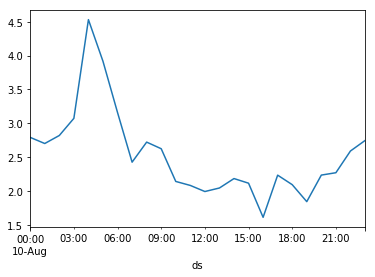

In [278]:
trip_df_all['263']['2018-08-10'].plot()

AVerage tips given to drivers

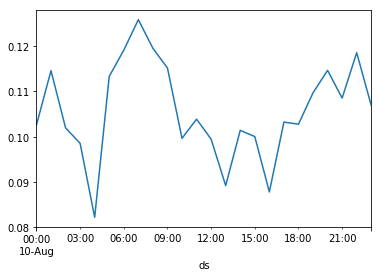

In [277]:
tips_df_all['263']['2018-08-10'].plot()

Yellow taxi pick-up demand

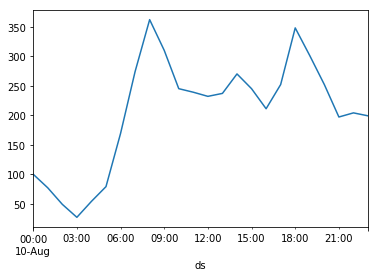

In [276]:
demand_df_all_2['263']['2018-08-10'].plot()

#### Hourly average fare paid by customers in Yorkville West neighborhood

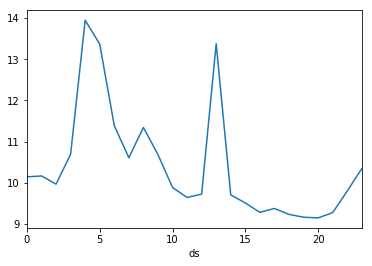

In [361]:
fare_df_all.groupby([fare_df_all.index.hour]).mean()['263'].plot()

#### Average fare paid by customers in June 2018 in Garment District

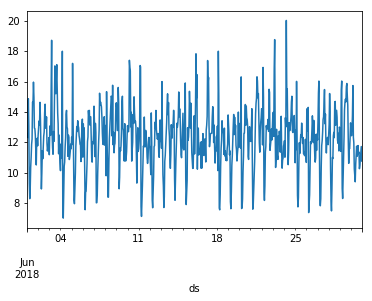

In [395]:
fare_df_all['100']['2018-06'].plot()

Hourly average in whole 2018

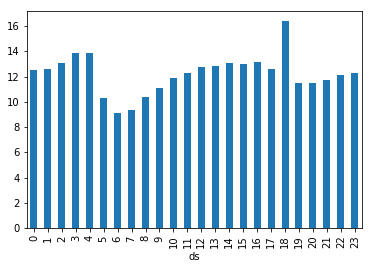

In [422]:
fare_df_all.groupby([fare_df_all.index.hour]).mean()['100'].plot(kind='bar')

#### Hourly and weekday average fare in Yorkwille East

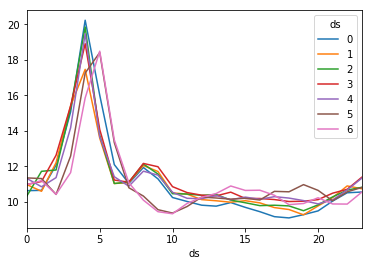

In [309]:
fare_df_all.groupby([fare_df_all.index.hour, fare_df_all.index.weekday]).mean()['262'].unstack().plot()

#### Saving lookup table

In [341]:
zone_lookup.to_csv('gcs://nyc-taxi-data-2018-2019/nyc_neighborhoods/zone_lookup.csv')